### Tasks
#### Replace Exact neighbors with LSH
#### Try multiple datasets
#### Create a script
#### add degub data points and make sure everything is correct (norm calculation) - possibly wrong
#### weird loss function could also lead to weird gradients
#### understand norm behavior

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import time
import copy
import os

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

In [2]:
torch.backends.cudnn.deterministic = True
random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(device)

cuda:5


In [4]:
dataset = 0 
if dataset == 0:
    df=pd.read_csv("HIGGS.csv",header=None, nrows=600000)
    df.head()
elif dataset == 1:
    df=pd.read_csv("SUSY.csv",header=None, nrows=600000)
    df.head()

In [5]:
print(df.size)

17400000


<AxesSubplot: xlabel='0', ylabel='count'>

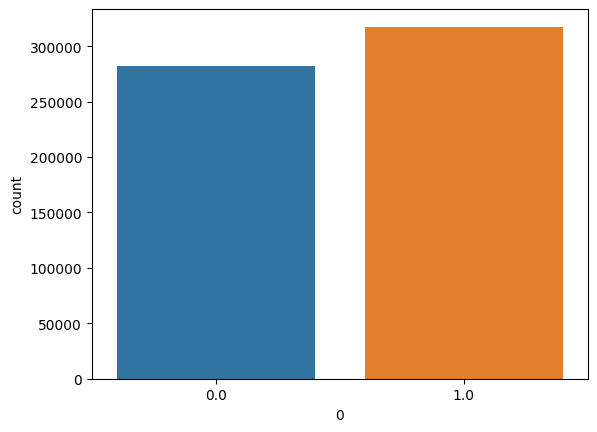

In [6]:
sns.countplot(x = 0, data=df)

In [7]:
X = df.iloc[:, 1:]  
y = df.iloc[:, 0]

In [8]:
EPOCHS = 50
BATCH_SIZE = 1024
LEARNING_RATE = 0.0001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 2
RANDOM_SIZE = [10, 20, 30, 40, 50, 0]

In [9]:
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    "LEARNING_RATE": {
        'value': LEARNING_RATE
        },
    "NUM_FEATURES": {
        'value': NUM_FEATURES
        },
    "NUM_CLASSES": {
        'value': NUM_CLASSES
        },
    "EPOCHS": {
        'value': EPOCHS
        },
    "RANDOM_SIZE":{
        'values':RANDOM_SIZE
        }
    }
# 
sweep_config['parameters'] = parameters_dict

In [10]:
sweep_id = wandb.sweep(sweep_config, project="ExactNeighbors-ImportanceSampling")

Create sweep with ID: x36ms5g3
Sweep URL: https://wandb.ai/rice-and-shine/ExactNeighbors-ImportanceSampling/sweeps/x36ms5g3


In [11]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [13]:
def get_class_distribution(obj):
    count_dict = {
        "class_0": 0,
        "class_1": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['class_0'] += 1
        elif i == 1: 
            count_dict['class_1'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

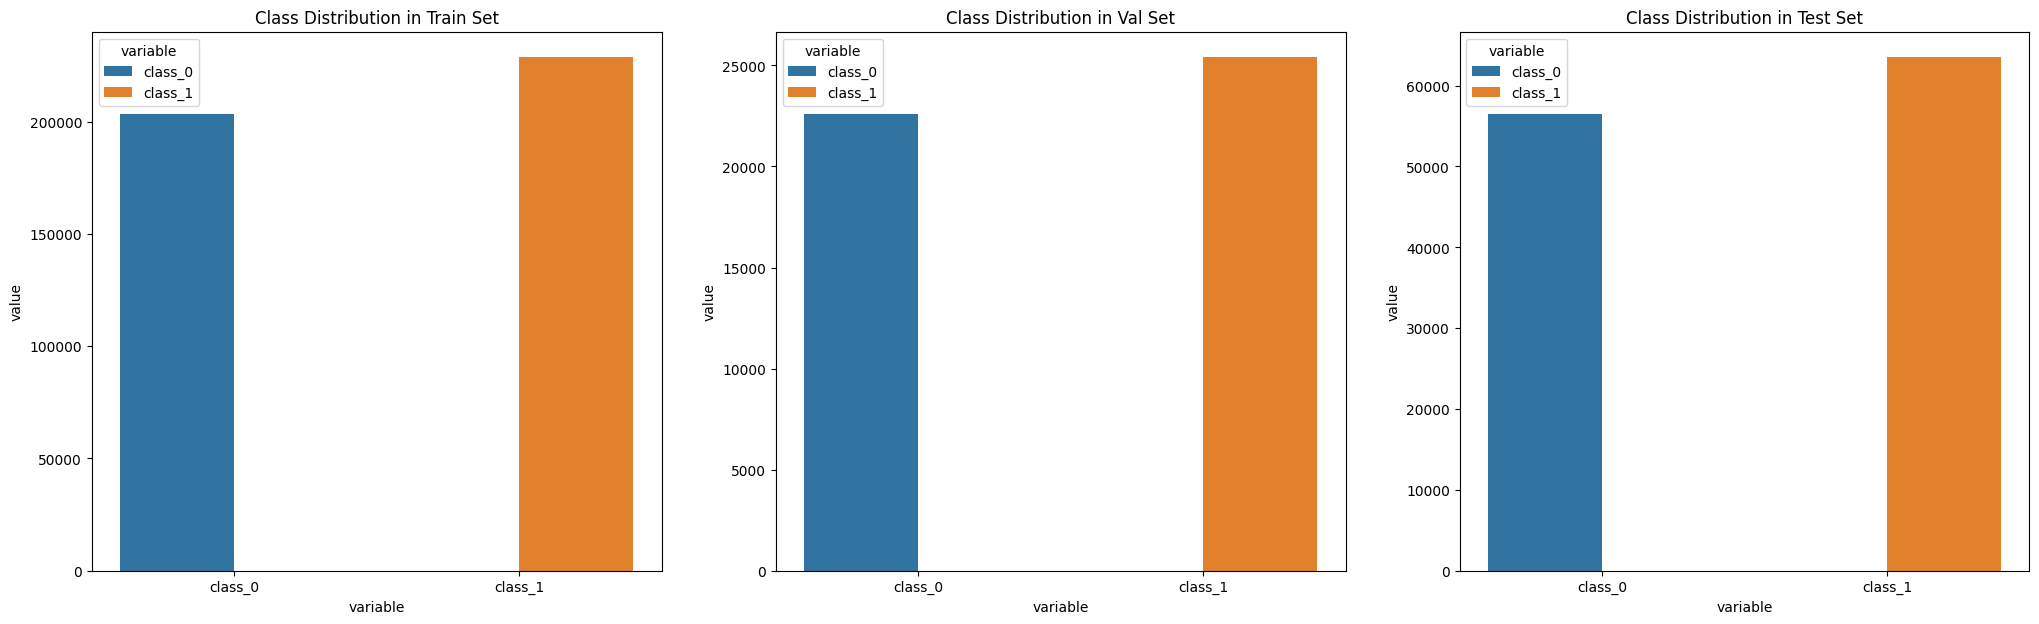

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [15]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
    def getBatch(self, indices, yclass = -1):
        if yclass >= 0:
            return self.X_data[self.y_data == yclass], self.y_data[self.y_data == yclass]
        else:
            return self.X_data[(indices)], self.y_data[(indices)]
    
    def getSplitbyClass(self, indices, yclass):
        return self.X_data[self.y_data == yclass][indices], self.y_data[self.y_data == yclass][indices]
    

train_dataset = ClassifierDataset(torch.tensor(X_train, dtype=torch.float32 ,device=device), torch.tensor(y_train, dtype=torch.long, device=device))
val_dataset = ClassifierDataset(torch.tensor(X_val, dtype=torch.float32, device=device), torch.tensor(y_val, dtype=torch.long, device=device))
test_dataset = ClassifierDataset(torch.tensor(X_test, dtype=torch.float32, device=device), torch.tensor(y_test, dtype=torch.long, device=device))

In [16]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 2048)
        self.layer_2 = nn.Linear(2048, 512)
        self.layer_3 = nn.Linear(512, 128)
        self.layer_out = nn.Linear(128, num_class)
        
        self.relu = nn.ReLU()
        
        self.batchnorm1 = nn.InstanceNorm1d(2048)
        self.batchnorm2 = nn.InstanceNorm1d(512)
        self.batchnorm3 = nn.InstanceNorm1d(128)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)

        
        x = self.layer_out(x)
        
        return x

In [17]:
class CrossEntropyLoss(nn.Module):
    """
    This criterion (`CrossEntropyLoss`) combines `LogSoftMax` and `NLLLoss` in one single class.
    
    NOTE: Computes per-element losses for a mini-batch (instead of the average loss over the entire mini-batch).
    """
    log_softmax = nn.LogSoftmax()

    def __init__(self):
        super().__init__()
        
    def forward(self, x, target, weights=[]):
        log_softmax =  x - x.exp().sum(-1).log().unsqueeze(-1)
        loss = -log_softmax[range(target.shape[0]), target]
        
        if len(weights) > 0:
            return (loss*weights/weights.sum()).sum()
        else:
            return loss.mean()

In [18]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [19]:
def compute_loss_stateless_model (params, buffers, sample, target):
    batch = sample.unsqueeze(0)
    targets = target.unsqueeze(0)

    predictions = fmodel(params, buffers, batch) 
    loss = torch.nn.functional.cross_entropy(predictions, targets)

    return loss

In [20]:
def compute_next_batch(batch, y, dataset, batch_norm, random_size):
       
    full_data_0 = dataset.getBatch(list(range(len(dataset))), yclass = 0)[0]
    full_data_1 = dataset.getBatch(list(range(len(dataset))), yclass = 1)[0]
    
    ## concatenate all top neighors into single tensor            
    next_batch_0 = torch.cat(tuple([torch.linalg.norm(full_data_0 - x, dim = 1).argsort()[1:33].cpu() \
                                   for sample, x in enumerate(batch) if y[sample] == 0]))
    next_batch_1 = torch.cat(tuple([torch.linalg.norm(full_data_1 - x, dim = 1).argsort()[1:33].cpu() \
                                   for sample, x in enumerate(batch) if y[sample] == 1]))
    
    ## assign probability of selection to all candidates in next batch
    next_batch_weights_0 = torch.cat(tuple([torch.tensor([x.item()]*32) for sample, x in enumerate(batch_norm) if y[sample] == 0]))
    next_batch_weights_1 = torch.cat(tuple([torch.tensor([x.item()]*32) for sample, x in enumerate(batch_norm) if y[sample] == 1]))
    
    ## weighted selection of next batch.
    next_batch_0 = next_batch_0[next_batch_weights_0.multinomial(int(BATCH_SIZE*random_size/200))]
    next_batch_1 = next_batch_1[next_batch_weights_1.multinomial(int(BATCH_SIZE*random_size/200))]
    
    #track clustering
    cluster[random_size][next_batch_0] += 1
    
    #concatenate points from both class
    X_0, y_0 = dataset.getSplitbyClass(next_batch_0, yclass = 0)
    X_1, y_1 = dataset.getSplitbyClass(next_batch_1, yclass = 1)
    
    return torch.cat((X_0, X_1)), torch.cat((y_0, y_1))
   

In [21]:
from functorch import make_functional_with_buffers, vmap, grad

base_model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
base_model.to(device)

MulticlassClassification(
  (layer_1): Linear(in_features=28, out_features=2048, bias=True)
  (layer_2): Linear(in_features=2048, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (batchnorm1): InstanceNorm1d(2048, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (batchnorm2): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (batchnorm3): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
)

In [22]:
ft_compute_grad = grad(compute_loss_stateless_model)
ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, None, 0, 0))

In [23]:
global cluster
cluster = dict()

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": [],
    "grad": []
}

In [24]:
def wandb_trainer_function(config=None):
    # INITIALIZE NEW WANDB RUN
    with wandb.init(config=config) as run:
        #USING THE CONFIG TO SET THE HYPERPARAMETERS FOR EACH RUN
        config = wandb.config
        wandb.define_metric("custom_step")
        wandb.define_metric("Train Loss", step_metric='custom_step')
        wandb.define_metric("Val Loss", step_metric='custom_step')
        wandb.define_metric("Train Accuracy", step_metric='custom_step')
        wandb.define_metric("Val Accuracy", step_metric='custom_step')
        wandb.define_metric("Gradient Norm", step_metric='custom_step')
        if config.RANDOM_SIZE > 0:
            run.name = "NN-"+str(config.RANDOM_SIZE)
        else:
            run.name = "RANDOM"
        
        torch.cuda.empty_cache()
        model = copy.deepcopy(base_model)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE - int(config.RANDOM_SIZE*BATCH_SIZE/100), shuffle=True)
        val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        print("Begin training.")
        for e in tqdm(range(1, EPOCHS+1)):
            train_epoch_loss=0
            train_epoch_acc=0
            val_epoch_loss = 0
            val_epoch_acc = 0
            gradient_norm_epoch = 0
            
            cluster[config.RANDOM_SIZE] = torch.zeros(len(train_dataset))

            model.train()
            pre_X, pre_y = next(iter(train_loader))
            for X, y in train_loader:
                
                optimizer.zero_grad()
                
                global fmodel
                fmodel, params, buffers = make_functional_with_buffers(model)
                
                if config.RANDOM_SIZE > 0:
                    #append near neighbors to current batch
                    X, y = torch.cat((pre_X, X)), torch.cat((pre_y, y)) 

                    
                pred = model(X)
                
                ### use functorch to calculate per sample gradient
                ft_per_sample_grads = ft_compute_sample_grad(params, buffers, X, y)

                ### calculate norm of the gradient and use it to compute next batch
                batch_norm = torch.zeros(X.size(0), device=device)
                for item in ft_per_sample_grads:
                    batch_norm +=  torch.linalg.norm(item, dim=tuple(range(1,len(item.shape))))
                gradient_norm_epoch += batch_norm.sum().item()/X.size(0)
                
                if config.RANDOM_SIZE > 0:
                    pre_X, pre_y = compute_next_batch(X, y, train_dataset, batch_norm, config.RANDOM_SIZE)

                train_loss = criterion(pred, y)
                train_loss.backward()
                optimizer.step()


            with torch.no_grad():
                model.eval()
                for X_val, y_val in val_loader:
                    val_pred = model(X_val)

                    val_loss = criterion(val_pred, y_val)
                    val_acc = multi_acc(val_pred, y_val)

                    val_epoch_loss += val_loss.item()
                    val_epoch_acc += val_acc.item()
                
                X_train_test, y_train_test = train_dataset.getBatch(list(range(20000)))
                train_test_pred = model(X_train_test)
                train_epoch_loss = criterion(train_test_pred, y_train_test).item()
                train_epoch_acc = multi_acc(train_test_pred, y_train_test).item()


            # TRAIN LOSS AND ACCURACY
            loss_stats['train'].append(train_epoch_loss)
            loss_stats['val'].append(val_epoch_loss/(len(val_loader)))
            loss_stats['grad'].append(gradient_norm_epoch/len(train_loader))

            accuracy_stats['train'].append(train_epoch_acc)
            accuracy_stats['val'].append(val_epoch_acc/(len(val_loader)))

            ## plot val loss and accuracy here. For train, standardise a subset for loss/accuracy
            print(f'Epoch {e+0:03}: | Train Loss: {loss_stats["train"][-1]:.5f} | Val Loss: {loss_stats["val"][-1]:.5f} | Train Acc: {accuracy_stats["train"][-1]:.3f} | Val Acc: {accuracy_stats["val"][-1]:.3f}')
            wandb.log({"Train Loss":loss_stats["train"][-1], "Val Loss":loss_stats["val"][-1],"Train Accuracy":accuracy_stats["train"][-1],"Val Accuracy":accuracy_stats["val"][-1], "Gradient Norm":loss_stats["grad"][-1], 'custom_step':e})

        plt.plot(cluster.sort(descending=True).values)

In [ ]:
wandb.agent(sweep_id, wandb_trainer_function)

wandb: Agent Starting Run: srh6nlnl with config:
wandb: 	EPOCHS: 50
wandb: 	LEARNING_RATE: 0.0001
wandb: 	NUM_CLASSES: 2
wandb: 	NUM_FEATURES: 28
wandb: 	RANDOM_SIZE: 10
wandb: Currently logged in as: aw82 (rice-and-shine). Use `wandb login --relogin` to force relogin


Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1844, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([1024, 28])
there
torch.Size([10

In [26]:
plt.plot(cluster.sort(descending=True).values)
plt.axhline(y = len(train_loader), color = 'r', linestyle = '-')

AttributeError: 'dict' object has no attribute 'sort'

In [ ]:
total_unique_calls = cluster.sum().int().item()
total_possible_calls = len(train_loader)*EPOCHS*(512)
overlapping_neighbors = total_possible_calls - total_unique_calls
total_unique_calls, total_possible_calls, overlapping_neighbors, max(cluster).int().item()

In [ ]:
plt.plot(cluster.sort(descending=True).values)